### Load the necessary packages

In [301]:
import os
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

from torch_lr_finder import LRFinder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

import itertools
from itertools import cycle

### Initalize parameters

In [142]:
# Location of data
data_dir = '../data/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

save_file_name = 'resnet50-transfer10.pt'
checkpoint_file_name = 'resnet50-transfer10.pth'

# Change to fit hardware
batch_size = 32

image_size = 224

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [143]:
# set random seeds
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

### Image Augmentation

In [144]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=image_size),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(45),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.CenterCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.CenterCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Data Iterators

In [231]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [233]:
# Datasets from each folder
data = {
    'train':
    ImageFolderWithPaths(root=train_dir, transform=image_transforms['train']),
    'val':
    ImageFolderWithPaths(root=valid_dir, transform=image_transforms['val']),
    'test':
    ImageFolderWithPaths(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=False)
}

### Model Setup
#### Load Pre-trained ResNet50Model

In [146]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Freeze weights of early layers of the VGG16 Model

In [147]:
for param in model.parameters():
    param.requires_grad = False

#### Replace Last layer with fully connected layer configured for the task at hand

In [148]:
n_classes = 101

n_inputs = model.fc.in_features

classifier = nn.Sequential(
    nn.Linear(n_inputs,image_size),
    nn.LeakyReLU(),
    nn.Linear(image_size,n_classes)
    )

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Move model to GPU

In [149]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

### Finding the Right Learning Rate

In order to use a Cyclic Learning Rate scheduler efficiently, you must first find the bounds between the upper and lower limit learning rates.

In [150]:
# # we will be using negative log likelihood as the loss function
# criterion = nn.CrossEntropyLoss()
# # we will be using the SGD optimizer as our optimizer
# optimizer = optim.SGD(model.fc.parameters(), lr=1e-4)
# lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
# lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=2500)
# lr_finder.plot()
# lr_finder.reset()

In [151]:
# # we will be using negative log likelihood as the loss function
# criterion = nn.CrossEntropyLoss()
# # we will be using the SGD optimizer as our optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-4)
# lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
# lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=2500)
# lr_finder.plot()
# lr_finder.reset()

### Training Loss and Optimizer

In [152]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the Adam optimizer as our optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=1e-1, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=1e-1, base_lr=1e-3, mode='triangular')

In [153]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader,
                valid_loader,
                save_file_name,
                checkpoint_file_name,
                early_stopping_patience=100,
                overfit_patience=15,
                n_epochs=25,
                print_every=2,
                valid_every=2
               ):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    # early stopping initializaiton
    epochs_no_improve = 0
    epochs_overfit = 0
    valid_loss_min = np.Inf
    
    valid_max_acc = 0
    history = []
    
    # number of epochs already trained (if using loaded in model weights)
    try:
        print("Model has been trained for: {} epochs.\n".format(model.epochs))
    except:
        model.epochs = 0
        print("Starting training from scratch.\n")
        
    overall_start = timer()
    
    #Main loop
    for epoch in range(n_epochs):
        
        #keep track of training and validation loss of each epoch
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0
        valid_acc = 0
        
        #set to training
        model.train()
        start = timer()
        
        # training loop
        for ii, (data, target) in enumerate(train_loader):
            #tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            # clear gradients
            optimizer.zero_grad()
            #predicted outpouts are log probabilities
            output = model(data)
            
            # loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            # calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
        # after training loop ends
        else:
            model.epochs += 1
            
            if model.epochs > 1 and (model.epochs % valid_every == 0): 
                # don't need to keep track of gradients
                with torch.no_grad():
                    # set to evaluation mode
                    model.eval()

                    #validation loop
                    for data, target in valid_loader:
                        #tensors to gpu
                        if train_on_gpu:
                            data, target = data.cuda(), target.cuda()

                        # Forward pass
                        output = model(data)

                        # validation loss 
                        loss = criterion(output, target)
                        # multiply average loss times the number of examples in batch
                        valid_loss += loss.item() * data.size(0)

                        # calculate validation accuracy
                        _, pred = torch.max(output, dim=1)
                        correct_tensor = pred.eq(target.data.view_as(pred))
                        accuracy = torch.mean(
                            correct_tensor.type(torch.FloatTensor))
                        # multiply average accuracy times the number of examples
                        valid_acc += accuracy.item() * data.size(0)

                    # calculate average losses
                    train_loss = train_loss / (len(train_loader.dataset))
                    valid_loss = valid_loss / (len(valid_loader.dataset))

                    # calculate average accuracy
                    train_acc = train_acc / (len(train_loader.dataset))
                    valid_acc = valid_acc / (len(valid_loader.dataset))

                    # learning rate scheduler step
                    scheduler.step(valid_loss)

                    history.append([train_loss, valid_loss, train_acc, valid_acc, model.epochs])

                    # Print training and validation results
                    if (model.epochs + 1) % valid_every == 0:
                        print(
                            f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                        )
                        print(
                            f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                        )

                    # save the model if validation loss decreases
                    if valid_loss < valid_loss_min:
                        print("Valid loss decreased ({:.6f} --> {:.6f}). Saving model...".format(valid_loss_min, valid_loss))

                        # save model
                        torch.save(model.state_dict(), save_file_name)

                        checkpoint = {
                            "model": model,
                            "criterion": criterion,
                            "epochs": model.epochs,
                            "optimizer_state": optimizer.state_dict(),
                            "model_state": model.state_dict(),
                            "valid_loss_min": valid_loss
                        }
                        torch.save(checkpoint, checkpoint_file_name)

                        # track improvements
                        epochs_no_improve = 0
                        epochs_overfit = 0
                        valid_loss_min = valid_loss
                        valid_best_acc = valid_acc
                        best_epoch = epoch

                    # otherwise increment count of epochs with no improvement
                    elif train_loss < valid_loss:
                        epochs_overfit += 1
                        if epochs_overfit >= overfit_patience:
                            print(f'\n Valid loss has increased larger than training loss for {epochs_overfit} epochs')
                            print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                            )
                            # load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # attach the optimizer
                            model.optimizer = optimizer

                            # format history
                            history = pd.DataFrame(
                                    history,
                                    columns=[
                                        'train_loss', 'valid_loss', 'train_acc',
                                        'valid_acc', 'epochs'
                                    ])
                            return model, history

                    else:
                        epochs_no_improve += 1
                        #trigger early stopping
                        # this should be not going bad
                        if (epochs_no_improve >= early_stopping_patience):
                            print(
                                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                            )
                            total_time = timer() - overall_start
                            print(
                                f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                            )

                            # load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # attach the optimizer
                            model.optimizer = optimizer

                            # format history
                            history = pd.DataFrame(
                                    history,
                                    columns=[
                                        'train_loss', 'valid_loss', 'train_acc',
                                        'valid_acc', 'epochs'
                                    ])
                            return model, history
                        
    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (model.epochs):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [15]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    early_stopping_patience=50,
    overfit_patience=10,
    n_epochs=200,
    print_every=1
    )

Starting training from scratch.

Epoch: 1	100.00% complete. 708.11 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 3.7033 	Validation Loss: 3.2606
		Training Accuracy: 21.49%	 Validation Accuracy: 26.83%
Valid loss decreased (inf --> 3.260641). Saving model...
Epoch: 3	100.00% complete. 713.82 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 2.9746 	Validation Loss: 2.6674
		Training Accuracy: 30.42%	 Validation Accuracy: 35.74%
Valid loss decreased (3.260641 --> 2.667352). Saving model...
Epoch: 5	100.00% complete. 710.21 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 2.7804 	Validation Loss: 2.5093
		Training Accuracy: 34.15%	 Validation Accuracy: 38.37%
Valid loss decreased (2.667352 --> 2.509253). Saving model...
Epoch: 7	100.00% complete. 710.25 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 2.6872 	Validation Loss: 2.4001
		Training Accuracy: 35.74%	 Validation Accuracy: 40.36%
Valid loss decreased (2.509253 --> 2.400139). Saving model...
Epoch: 9	100.00% complete. 7

Valid loss decreased (1.891438 --> 1.871782). Saving model...
Epoch: 163	100.00% complete. 707.40 seconds elapsed in epoch.
Epoch: 163 	Training Loss: 2.1052 	Validation Loss: 1.8869
		Training Accuracy: 47.97%	 Validation Accuracy: 51.90%
Epoch: 165	100.00% complete. 713.18 seconds elapsed in epoch.
Epoch: 165 	Training Loss: 2.0978 	Validation Loss: 1.9131
		Training Accuracy: 48.13%	 Validation Accuracy: 51.42%
Epoch: 167	100.00% complete. 707.75 seconds elapsed in epoch.
Epoch: 167 	Training Loss: 2.0963 	Validation Loss: 1.9046
		Training Accuracy: 48.00%	 Validation Accuracy: 51.74%
Epoch: 169	100.00% complete. 706.99 seconds elapsed in epoch.
Epoch: 169 	Training Loss: 2.0974 	Validation Loss: 1.9089
		Training Accuracy: 47.91%	 Validation Accuracy: 51.86%
Epoch: 171	100.00% complete. 707.28 seconds elapsed in epoch.
Epoch: 171 	Training Loss: 2.0900 	Validation Loss: 1.9086
		Training Accuracy: 48.15%	 Validation Accuracy: 51.99%
Epoch: 173	100.00% complete. 707.63 seconds elap

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

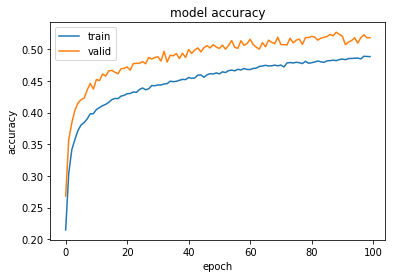

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

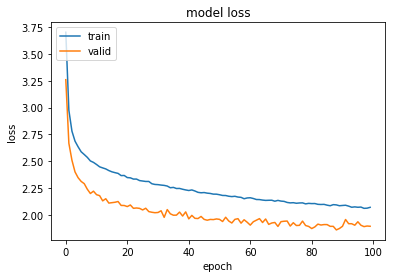

In [29]:

# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('train_valid_accuracy.png')
plt.show()


# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('train_valid_loss.png')

plt.show()


In [19]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the Adam optimizer as our optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=1e-1, base_lr=1e-3, mode='triangular')

In [31]:
for param in model.parameters():
    param.requires_grad = True

In [32]:
torch.cuda.empty_cache()

In [41]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    early_stopping_patience=50,
    overfit_patience=10,
    n_epochs=200,
    print_every=1
    )

Model has been trained for: 224 epochs.

Epoch: 1	100.00% complete. 1355.44 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.8272 	Validation Loss: 1.0429
		Training Accuracy: 77.49%	 Validation Accuracy: 73.89%
Valid loss decreased (inf --> 1.042851). Saving model...
Epoch: 3	100.00% complete. 1345.83 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7998 	Validation Loss: 1.0797
		Training Accuracy: 78.09%	 Validation Accuracy: 73.20%
Epoch: 5	100.00% complete. 1342.95 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.7798 	Validation Loss: 1.0316
		Training Accuracy: 78.69%	 Validation Accuracy: 74.18%
Valid loss decreased (1.042851 --> 1.031629). Saving model...
Epoch: 7	100.00% complete. 1336.51 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.7614 	Validation Loss: 1.0605
		Training Accuracy: 79.20%	 Validation Accuracy: 73.61%
Epoch: 9	100.00% complete. 1339.84 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.7289 	Validation Loss: 1.0233
		Training Accuracy: 7

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

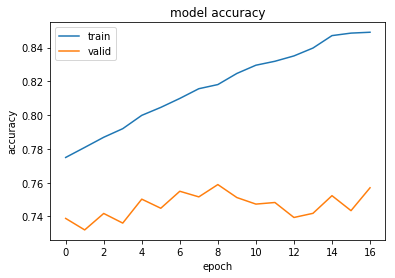

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

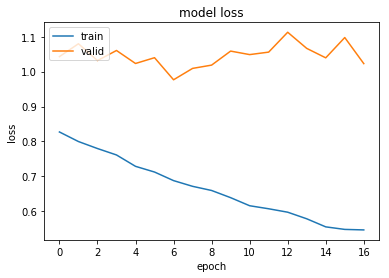

In [43]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Model Evaluation

In [154]:
def get_labels():
    food_labels = pd.read_csv("../data/meta/labels.txt", header=None)
    food_labels = food_labels[0].tolist()
    return food_labels

In [155]:
if train_on_gpu:
    model.load_state_dict(torch.load('../saved_models/resnet50-transfer10.pt', map_location= torch.device('cuda')))
    model.to('cuda')
else:
    model.load_state_dict(torch.load('../saved_models/resnet50-transfer10.pt', map_location= torch.device('cpu')))
    model.to('cpu')
model.eval()

<All keys matched successfully>

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [254]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [160]:
def imshow(img,normalizer):
    img = normalizer(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

imshow(images[30],unorm)


In [164]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
total_correct = 0
total = 0
y_test = []
y_pred = []

with torch.no_grad():
    for data, target in dataloaders['test']:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        y_test.extend(target.cpu().numpy().tolist())
        y_pred.extend(predicted.cpu().numpy().tolist())
        c = (predicted == target).squeeze()
        total += labels.size(0)
        total_correct += (predicted == target).sum().item()
        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of the network on the 12625 test images: %d %%' % (
    100 * total_correct / total))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 74 %
Accuracy of apple_pie : 50 %
Accuracy of baby_back_ribs : 73 %
Accuracy of baklava : 81 %
Accuracy of beef_carpaccio : 75 %
Accuracy of beef_tartare : 64 %
Accuracy of beet_salad : 68 %
Accuracy of beignets : 80 %
Accuracy of bibimbap : 81 %
Accuracy of bread_pudding : 50 %
Accuracy of breakfast_burrito : 56 %
Accuracy of bruschetta : 67 %
Accuracy of caesar_salad : 84 %
Accuracy of cannoli : 83 %
Accuracy of caprese_salad : 77 %
Accuracy of carrot_cake : 64 %
Accuracy of ceviche : 68 %
Accuracy of cheese_plate : 84 %
Accuracy of cheesecake : 68 %
Accuracy of chicken_curry : 68 %
Accuracy of chicken_quesadilla : 75 %
Accuracy of chicken_wings : 82 %
Accuracy of chocolate_cake : 69 %
Accuracy of chocolate_mousse : 54 %
Accuracy of churros : 84 %
Accuracy of clam_chowder : 68 %
Accuracy of club_sandwich : 79 %
Accuracy of crab_cakes : 73 %
Accuracy of creme_brulee : 88 %
Accuracy of croque_madame : 76 %
Accuracy of cup_cakes : 80 %
A

In [165]:
print('Classification Report')
print(classification_report(y_test, y_pred[:12625], target_names=get_labels()))

Classification Report
                         precision    recall  f1-score   support

              Apple pie       0.61      0.50      0.55       125
         Baby back ribs       0.67      0.74      0.70       125
                Baklava       0.86      0.82      0.84       125
         Beef carpaccio       0.77      0.75      0.76       125
           Beef tartare       0.68      0.64      0.66       125
             Beet salad       0.69      0.68      0.68       125
               Beignets       0.93      0.80      0.86       125
               Bibimbap       0.89      0.82      0.85       125
          Bread pudding       0.56      0.50      0.53       125
      Breakfast burrito       0.63      0.57      0.60       125
             Bruschetta       0.68      0.67      0.67       125
           Caesar salad       0.74      0.84      0.79       125
                Cannoli       0.84      0.83      0.84       125
          Caprese salad       0.78      0.78      0.78       125
  

#### Plot confusion Matrix

In [307]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          cax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


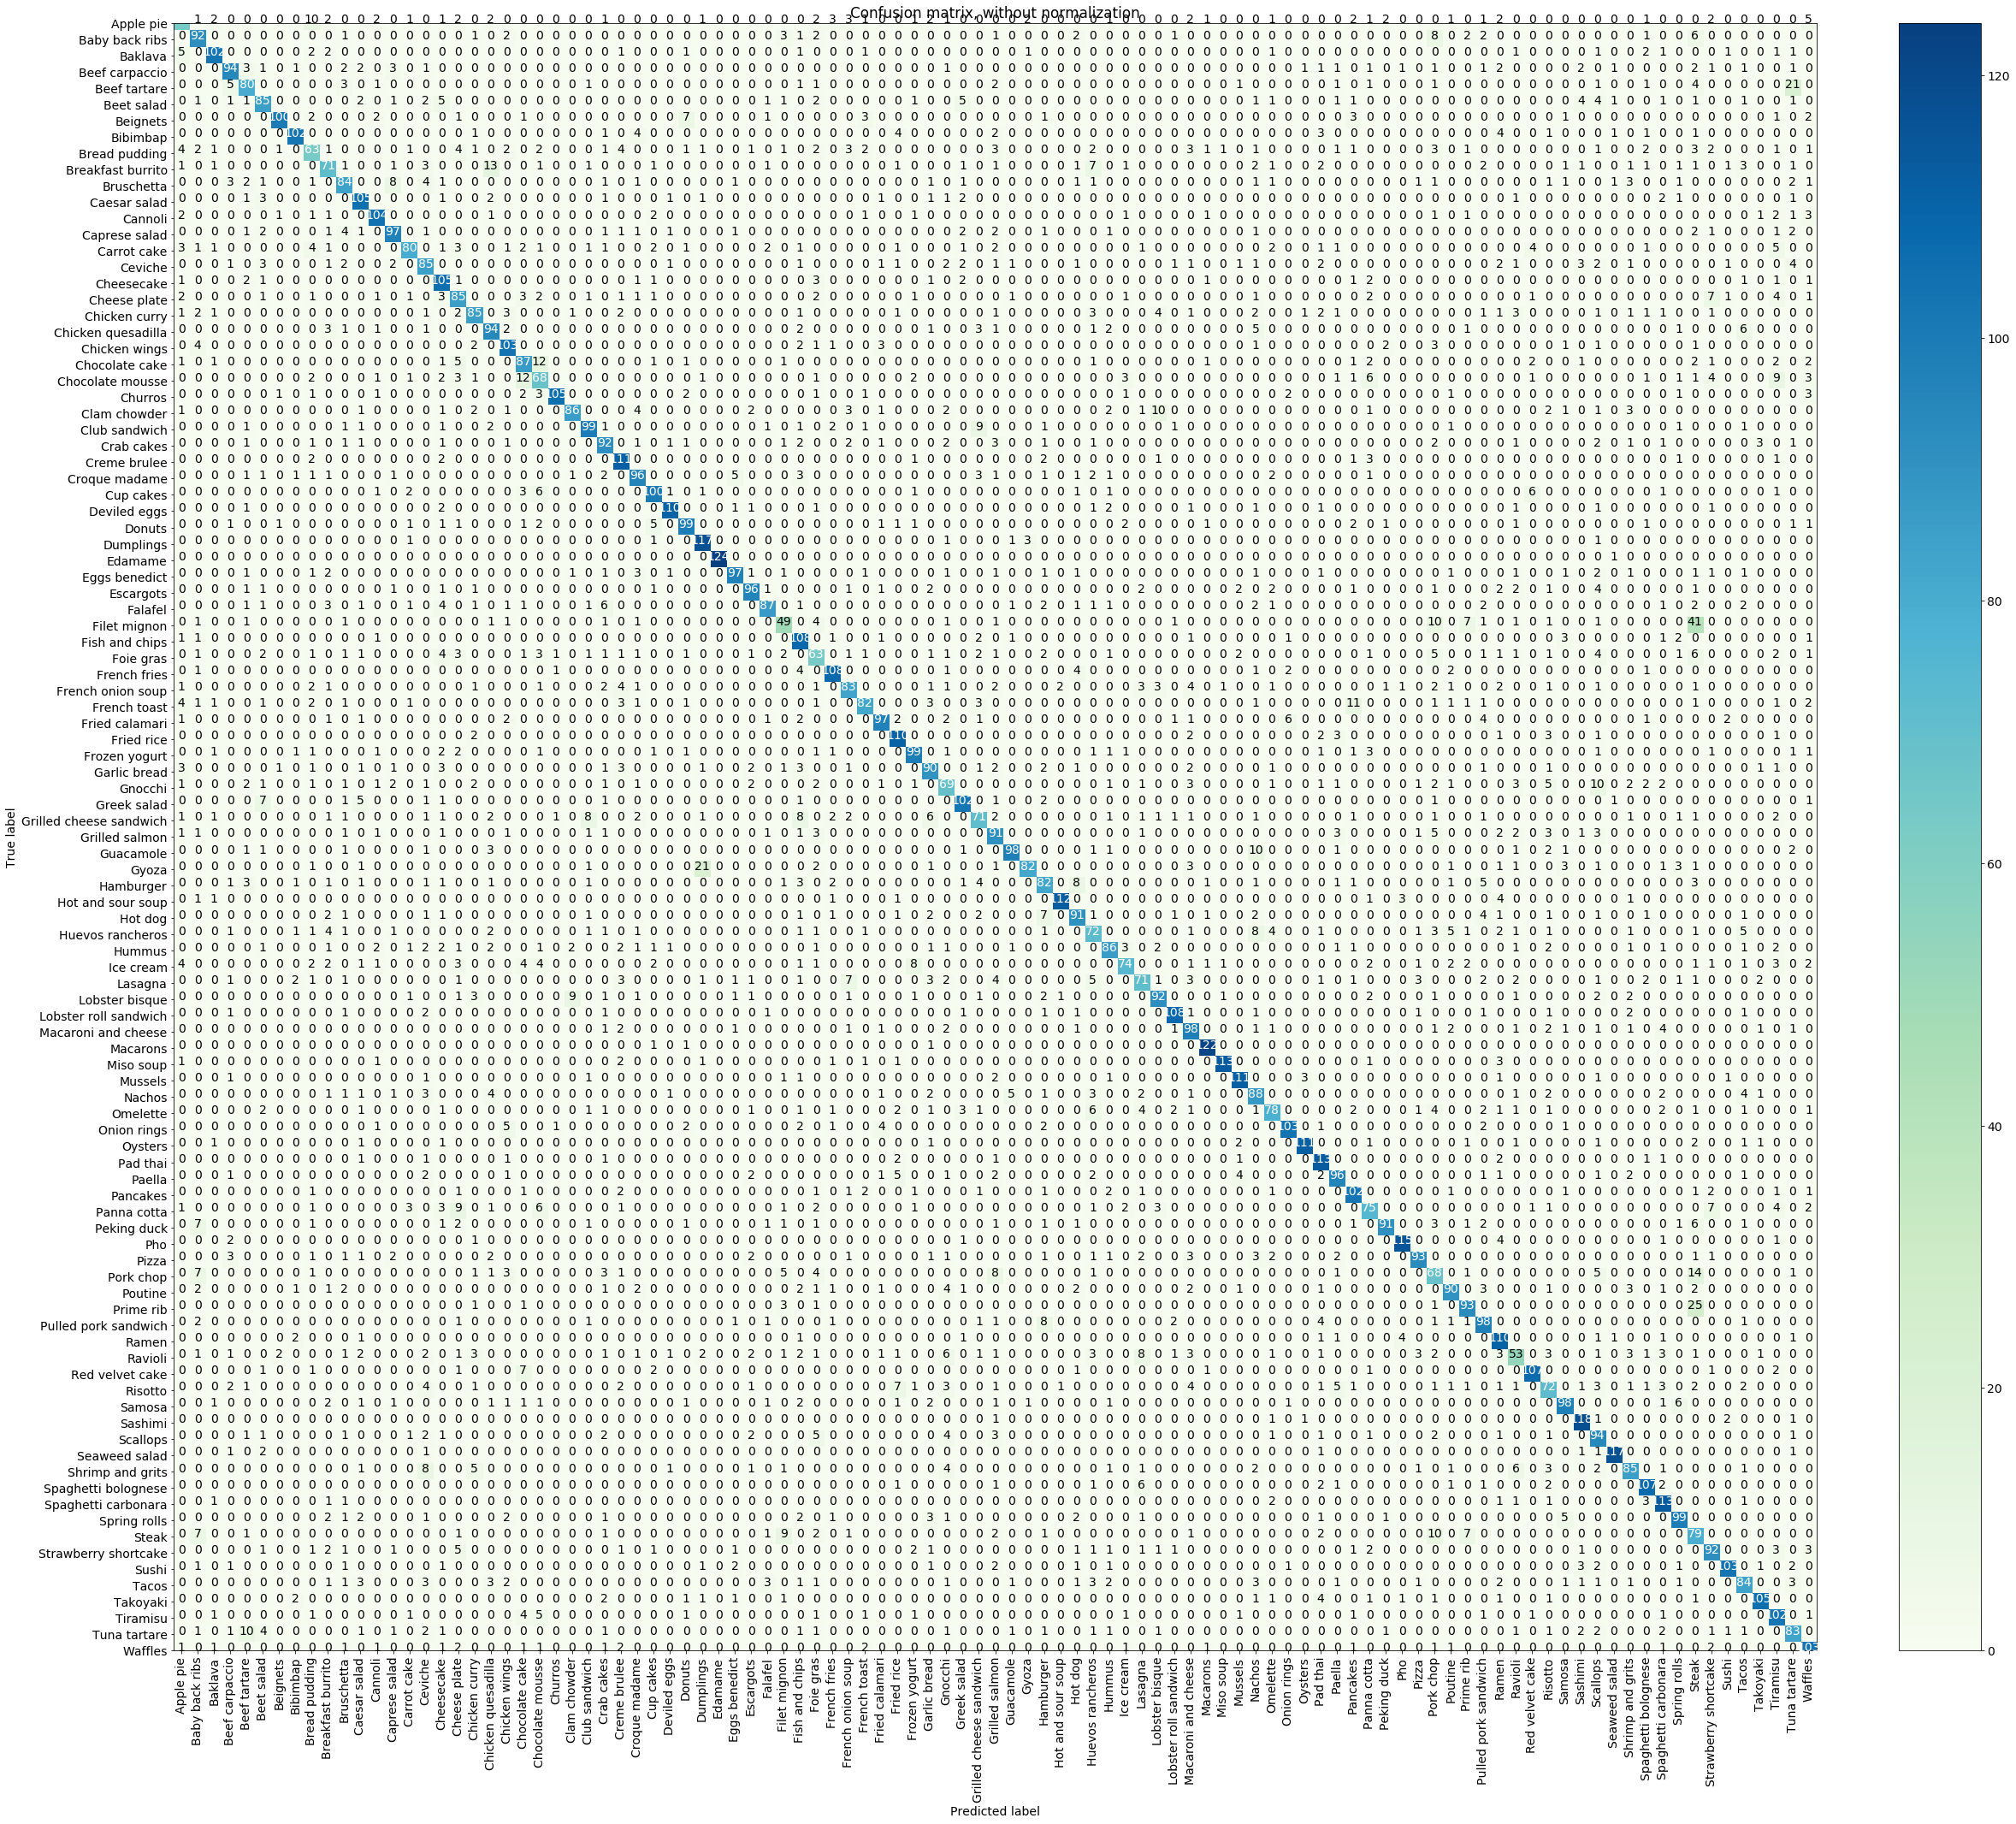

In [308]:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(35,35)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=get_labels(),
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.GnBu,cax=cax)

axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

plt.colorbar(cax=axins)

plt.show()

This confusion martrix plots the true identifications on the diagonal and the wrong classificationson every other spot. The Columns represent the predicted class and the rows represent the actual class.

In [229]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [230]:
auc = multiclass_roc_auc_score(y_test, y_pred)
print("Multi-Class AUC Score is: {}".format(auc))

Multi-Class AUC Score is: 0.8719999999999999


There is a multi-class AUC score of .87 which means the predictions are quite accurate.

In [279]:
def show_images_prediction(food_class,y_test, page=0):
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    fig.tight_layout()
    labels = get_labels()
    start_i = (labels.index(food_class) * 125) + (page * 20)

    for i, ax in enumerate(axes.flat):

        im = ax.imshow(plt.imread(data['test'][i+start_i][2]))
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = labels[y_pred[i+start_i]]
        match = predicted ==  labels[y_test[start_i + i]]
        ec = (1, .5, .5)
        fc = (1, .8, .8)
        if match:
            ec = (0, .6, .1)
            fc = (0, .7, .2)
        # predicted label
        ax.text(0, 350, 'P: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="round",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 440, 'A: ' + labels[y_test[start_i + i]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="round",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()

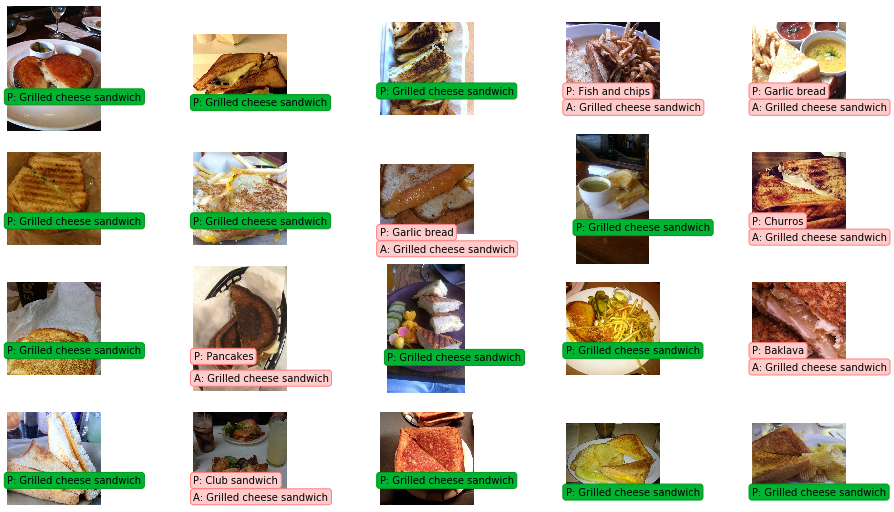

In [286]:
# change the first parameter to the class label you would like to examine.
# if you would like to check different images of the class increase the page number
show_images_prediction('Grilled cheese sandwich', y_test, page=2)

After observing some different pages above, it is clear that building a food classifier is not easy. With the understanding of how a CNN gets features and uses them to build predictions, it is possible to see why the model made some of the wrong predictions that it did. 

Some other food labels may have very similar shapes and colors, which could trick the model into thinking the image was of a different class.

Or in the case of sushi, there are very different type of shapes, colors, and arrangements of the food.

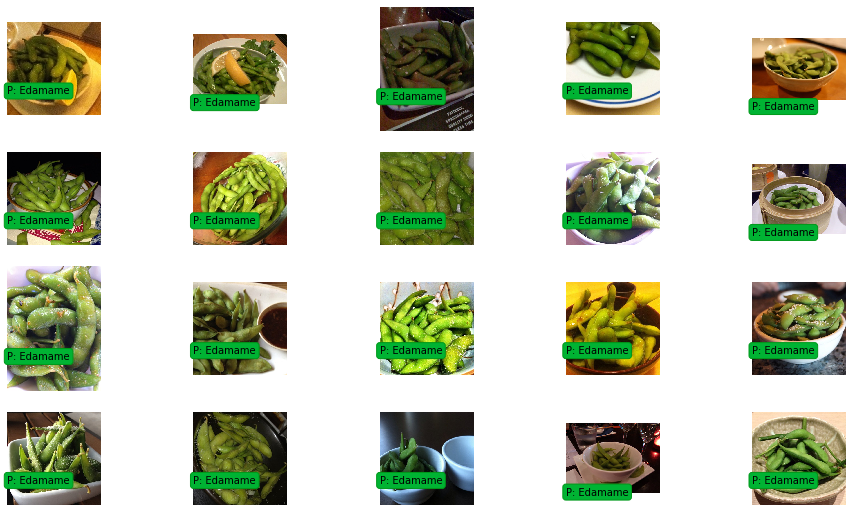

In [285]:
# change the first parameter to the class label you would like to examine.
# if you would like to check different images of the class increase the page number
show_images_prediction('Edamame', y_test, page=0)